In [23]:
#%%writefile ../crypto_chaotic/lorenz_attractor.py
import numpy as np
from math import sin, cos, sqrt

class Lorenz_Attractor:
    def __init__(self,N = 3, tstep = 0.0001, ndrop = 15000, 
                 rho = 25, sigma = 10, beta = 1.5, 
                 blocksize = 102400, pregen=True):
        self.rho = rho
        self.sigma = sigma
        self.beta = beta
        self.N = N
        self.tstep = tstep
        self.ndrop = ndrop
        self.pregen = pregen
        self.blocksize = blocksize
        if self.pregen:
            self.xt = self.pre_generate(self.blocksize)

    def deriv_send(self, xdot, x):
        xdot[0]=self.sigma * (x[1] - x[0])
        xdot[1]=x[0] * self.rho - x[1] - x[0] * x[2]
        xdot[2]=x[0] * x[1] - self.beta * x[2]
        return 0

    def deriv_receive(self, xdot, x, xp):
        xdot[0]=self.sigma * (x[1] - x[0])
        xdot[1]=xp * self.rho - x[1] - xp * x[2]
        xdot[2]=xp * x[1] - self.beta * x[2]
        return 0

    def rkm_send(self, h, x, N):
        xdot0 = np.zeros(N, dtype=np.float64)
        xdot1 = np.zeros(N, dtype=np.float64)
        xdot2 = np.zeros(N, dtype=np.float64)
        xdot3 = np.zeros(N, dtype=np.float64)
        g = np.zeros(N, dtype=np.float64)

        hh = h * 0.5
        self.deriv_send(xdot0, x)
        for i in range(N):
            g[i] = x[i] + hh * xdot0[i]

        self.deriv_send(xdot1, g)
        for i in range(N):
            g[i] = x[i] + hh * xdot1[i]

        self.deriv_send(xdot2, g)
        for i in range(N):
            g[i] = x[i] + h * xdot2[i]

        self.deriv_send(xdot3, g)
        for i in range(N):
            x[i] = x[i] + h * (xdot0[i] + 2.0 * 
                               (xdot1[i] + xdot2[i]) + 
                               xdot3[i]) / 6.0
        return 0

    def rkm_receive(self, h, x, xp, N):
        xdot0 = np.zeros(N, dtype=np.float64)
        xdot1 = np.zeros(N, dtype=np.float64)
        xdot2 = np.zeros(N, dtype=np.float64)
        xdot3 = np.zeros(N, dtype=np.float64)
        g = np.zeros(N, dtype=np.float64)

        hh = h * 0.5
        self.deriv_receive(xdot0, x, xp)
        for i in range(N):
            g[i] = x[i] + hh * xdot0[i]

        self.deriv_receive(xdot1, g, xp)
        for i in range(N):
            g[i] = x[i] + hh * xdot1[i]

        self.deriv_receive(xdot2, g, xp)
        for i in range(N):
            g[i] = x[i] + h * xdot2[i]

        self.deriv_receive(xdot3, g, xp)
        for i in range(N):
            x[i] = x[i] + h * (xdot0[i] + 2.0 * 
                               (xdot1[i] + xdot2[i]) + 
                               xdot3[i]) / 6.0

        return 0


    def pre_generate(self, nosdata):
        xt = np.zeros(nosdata, dtype=np.float64)

        xold = np.random.uniform(0, 1, size=self.N)    
        for i in range(self.ndrop):
            self.rkm_send(self.tstep, xold, self.N)

        for i in range(nosdata):
            self.rkm_send(self.tstep, xold, self.N)
            xt[i] = xold[0]
        return xt

    def chaos_encrypt(self, signal):
        nosdata = len(signal)
        encryptedx = np.zeros(nosdata, dtype=np.float64)

        if not self.pregen:
            xt = self.pre_generate(nosdata)
        else:
            xt = np.tile(self.xt, nosdata/self.blocksize)
            print len(xt), len(self.xt), nosdata, self.blocksize
            
        for i in range(nosdata):
            encryptedx[i] =  signal[i] + xt[i]

        return encryptedx, xt
    
    def chaos_encrypt_block(self, signal):
        nosdata = len(signal)
        encryptedx = np.zeros(nosdata, dtype=np.float64)
        xt = np.zeros(self.blocksize, dtype=np.float64)

        if not self.pregen:
            xt = self.pre_generate(self.blocksize)
        else:
            xt = self.xt
            
        xt = np.tile(xt, nosdata/self.blocksize)
        
        encryptedx =  signal + xt

        return encryptedx, xt
        
    def chaos_decrypt(self, encryptedx):
        nosdata = len(encryptedx)

        xr = np.zeros(nosdata, dtype=np.float64)
        recovered = np.zeros(nosdata, dtype=np.float64)

        xold = np.random.uniform(0, 1, size=self.N)
        for i in range(self.ndrop):
            self.rkm_send(self.tstep, xold, self.N)

        for i in range(nosdata):
            self.rkm_receive(self.tstep, xold, encryptedx[i], self.N)
            xr[i] = xold[0]

        for i in range(nosdata):
            recovered[i] = encryptedx[i] - xr[i]

        return recovered, xr
        
    def chaos_decrypt_block(self, encryptedx):
        nosdata = len(encryptedx)

        xr = np.zeros(nosdata, dtype=np.float64)
        recovered = np.zeros(nosdata, dtype=np.float64)
        
        xold = np.random.uniform(0, 1, size=self.N)
        for i in range(self.ndrop):
            self.rkm_send(self.tstep, xold, self.N)
        
        for j in range(nosdata/self.blocksize):
            xold1 = np.copy(xold)
            #print xold1
            for i in range(self.blocksize):
                self.rkm_receive(self.tstep, xold1, encryptedx[self.blocksize*j + i], self.N)
                xr[self.blocksize*j + i] = xold1[0]
            #print xold, xold1

            for i in range(nosdata):
                recovered[i] = encryptedx[i] - xr[i]

        return recovered, xr

In [24]:
#%%writefile ../crypto_chaotic/modulation.py
import numpy as np
from math import sin, cos, sqrt, pi
import matplotlib.pyplot as plt

def drawfft(signals, xlow=0, xhigh=0, ylow=0, yhigh=0):
    plt.figure(figsize=(15, 5))    
    if xlow < xhigh:
        plt.xlim([xlow,xhigh])
    if ylow < yhigh:
        plt.ylim([ylow,yhigh])
        
    for i in signals:
        sp = np.abs(np.fft.fft(i))
        freq = np.fft.fftfreq(len(sp), 1)

        Nindex = np.argmax(freq < 0)
        #freq1 = np.append(freq[Nindex:], freq[:Nindex])
        #sp1 = np.append(sp[Nindex:], sp[:Nindex])
        freq1 = freq[:Nindex]
        sp1 = sp[:Nindex]
        plt.plot(freq1, sp1)
    plt.show()
    
def plotamp(signals, xmin = 0, xmax = 0):    
    plt.figure(figsize=(15, 5))    
    x = range(len(signals[0]))
    if xmin < xmax:
        xi, xl = (xmin, xmax);
    else:
        xi, xl = (0, -1);
    print xi, xl
    for i in signals:
        plt.plot(x[xi: xl],i[xi: xl])
    plt.show()
    
class Modulation:
    def __init__(self, p = 100, sampling = 1, E=1):
        self.times = sampling
        self.p = p
        self.Scarrier  = np.array([E * sin((2*pi/self.p) * i)     for i in range(self.p*self.times)], dtype=np.float)
        self.NScarrier = np.array([E * sin((2*pi/self.p) * i+ pi) for i in range(self.p*self.times)], dtype=np.float)
        self.Ccarrier  = np.array([E * cos((2*pi/self.p) * i)     for i in range(self.p*self.times)], dtype=np.float)
        self.NCcarrier = np.array([E * cos((2*pi/self.p) * i+ pi) for i in range(self.p*self.times)], dtype=np.float)
    
    def qpsk_modulate(self, signal):
        nosdata = len(signal)
        modsig = np.array([], dtype=np.float)
        for i in range(nosdata):
            modsig = np.append(modsig, self.NScarrier)
            sig = int(signal[i])
            for k in range(32):
                if sig&0x01:
                    S = self.NScarrier
                else:
                    S = self.Scarrier

                if sig&0x02:
                    C = self.NCcarrier
                else:
                    C = self.Ccarrier
                modsig = np.append(modsig, S + C)
                sig = sig >> 2

        return modsig



    def qpsk_demodulate(self, modsig):
        nosdata = len(modsig)/(self.p*self.times*33)
        val = []
        rval = 0
        print nosdata
        for i in range(nosdata):
            for k in range(32):
                if np.std(self.Scarrier + modsig[(i*33+k+1)*self.p*self.times:(i*33+k+2)*self.p*self.times]) < E:
                    cval = 1
                else:
                    cval = 0
                if np.std(self.Ccarrier + modsig[(i*33+k+1)*self.p*self.times:(i*33+k+2)*self.p*self.times]) < E:
                    sval = 1
                else:
                    sval = 0
                dval = cval ^ sval <<1

                rval = rval ^ dval <<(k*2)
            val.append(rval)
            rval = 0

        return np.array(val, dtype=np.uint64)


Populating the interactive namespace from numpy and matplotlib
CPU times: user 985 µs, sys: 0 ns, total: 985 µs
Wall time: 923 µs
signal 100
CPU times: user 2.81 s, sys: 893 µs, total: 2.81 s
Wall time: 2.81 s
modsig 1584000
0 20000


`%matplotlib` prevents importing * from pylab and numpy


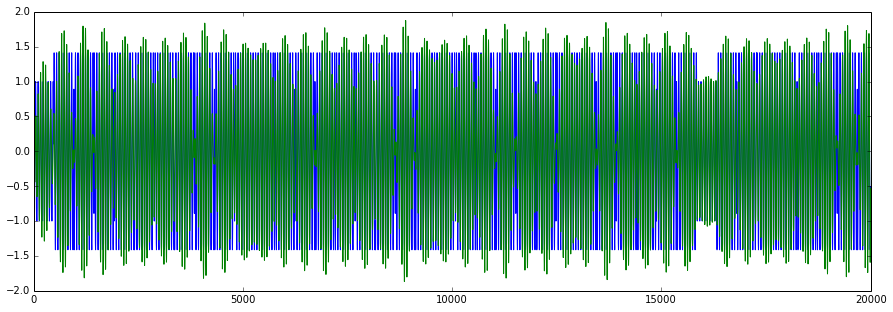

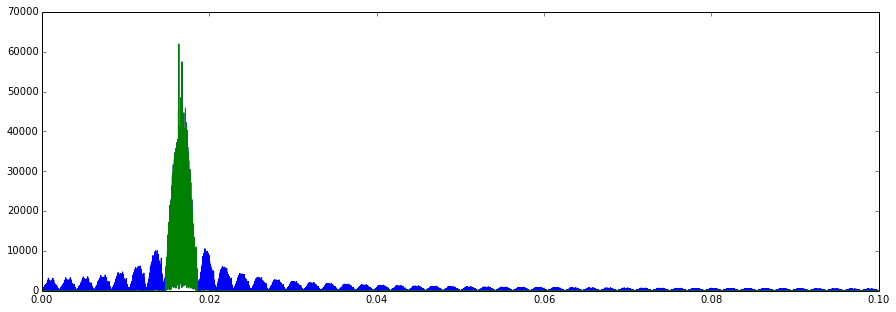

In [66]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
#from crypto_chaotic import lorenz_attractor
from scipy.fftpack import rfft, irfft, fftfreq

nosdata = 100
p = 60
E = 1.0
sampling = 8 #5
filter_del = 0.0038
blocksize = p*sampling*33

tstep = 0.01
ndrop = 150 #15000
N = 3
rho=25
sigma=10
beta=1.5

modulation = Modulation(p = p, sampling = sampling, E = E)
lorenz_attractor = Lorenz_Attractor(N = N, tstep = tstep, ndrop = ndrop, 
                                    rho = rho, sigma = sigma, beta = beta, 
                                    blocksize = blocksize, pregen=False)
#########################################
###     Random Signal Generation      ###
#########################################
%time signal = np.array([randrange(0, 2**64) for i in range(nosdata)], dtype=np.uint64)
#signalbypass = np.zeros(nosdata*32*p*sampling, dtype=np.uint64)
print "signal", len(signal)

#########################################
###          QPSK Modulation          ###
#########################################
%time modsig = modulation.qpsk_modulate(signal)
print "modsig", len(modsig)

#########################################
###         Frequency Domain          ###
#########################################
W = fftfreq(modsig.size, d=1)
f_signal = rfft(modsig)

#########################################
###              Filter               ###
#########################################
cut_f_signal = f_signal.copy()
#print (W<0.5/p)
cut_f_signal[(W>(2.0/p)+filter_del)] = 0
cut_f_signal[(W<(2.0/p)-filter_del)] = 0

#########################################
###            Time Domain            ###
#########################################
modsig_cut_signal = irfft(cut_f_signal)

#encryptedx, xt = lorenz_attractor.chaos_encrypt(signalbypass, N = N, tstep = tstep, ndrop = ndrop)  

plotamp([modsig, modsig_cut_signal], xmin = 0, xmax = 20000)

drawfft([modsig, modsig_cut_signal
                   ], xlow=0, xhigh=0.1, ylow=0, yhigh=0)

In [67]:
#lorenz_attractor = Lorenz_Attractor(N = N, tstep = tstep, ndrop = ndrop, 
#                                    rho = 540, sigma = 18.6, beta = 0.8,
#                                    #rho = 242, sigma = 10, beta = 0.2,
#                                    blocksize = blocksize, pregen=False)
#########################################
###           Chaos Encrypt           ###
#########################################
encryptedx = np.array([], dtype=np.uint64)
xt = np.array([], dtype=np.uint64)

print blocksize*2, len(modsig_cut_signal), (1.0* len(modsig_cut_signal))/blocksize
%time encryptedx, xt = lorenz_attractor.chaos_encrypt_block(modsig_cut_signal)

31680 1584000 100.0
CPU times: user 389 ms, sys: 5.03 ms, total: 394 ms
Wall time: 389 ms


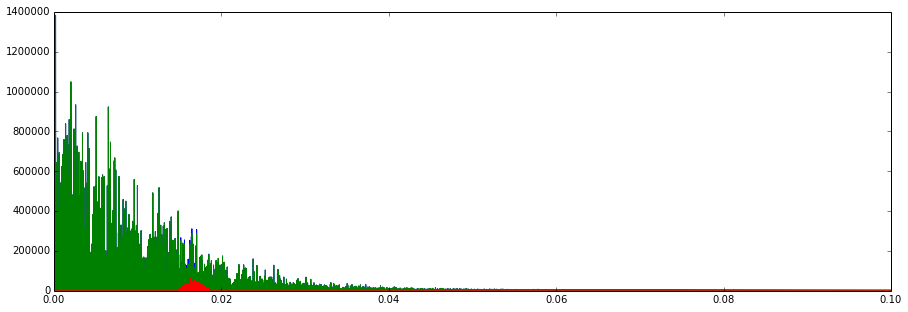

In [68]:
drawfft([encryptedx, xt, modsig_cut_signal], xlow=0, xhigh=0.1, ylow=0, yhigh=0)

In [69]:
#########################################
###           Chaos Decrypt           ###
#########################################
    
%time recovered, xr = lorenz_attractor.chaos_decrypt_block(encryptedx)

CPU times: user 1min 20s, sys: 87.3 ms, total: 1min 20s
Wall time: 1min 20s


In [70]:
#########################################
###         Frequency Domain          ###
#########################################
W = fftfreq(recovered.size, d=1)
f_signal = rfft(recovered)
#W = fftfreq(encryptedx.size, d=1)
#f_signal = rfft(encryptedx)
#W = fftfreq(modsig_cut_signal.size, d=1)
#f_signal = rfft(modsig_cut_signal)

#########################################
###              Filter               ###
#########################################
cut_f_signal = f_signal.copy()
#print (W<0.5/p)
#cut_f_signal[(W<1/p)] = 0
#cut_f_signal[(W>0/p)] = 0
cut_f_signal[(W>(2.0/p)+filter_del)] = 0
cut_f_signal[(W<(2.0/p)-filter_del)] = 0
#print 0.9/p, 0.5/p

#########################################
###            Time Domain            ###
#########################################
recovered_cut_signal = irfft(cut_f_signal)

#########################################
###        QPSK Demodulation          ###
#########################################
dmodsig = modulation.qpsk_demodulate(recovered_cut_signal)

#########################################
###        Comparing Signals          ###
#########################################
#print signal, dmodsig
if (signal == dmodsig).all():
    print 'matched'
else:
    print 'error'    
print signal == dmodsig

100
matched
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


0 2000


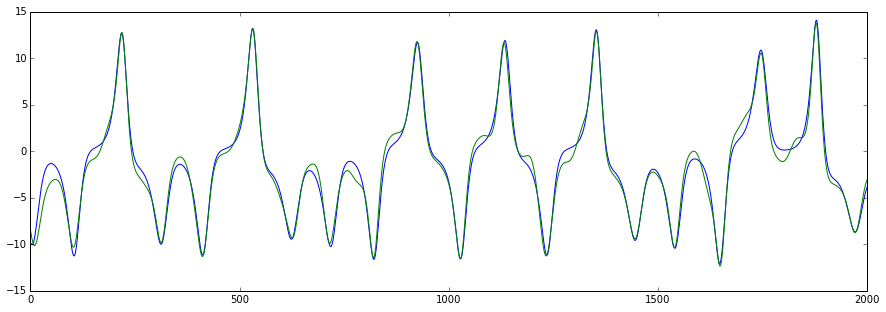

0 2000


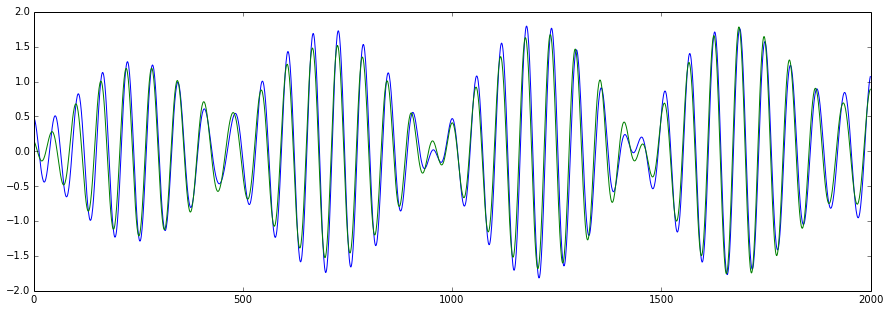

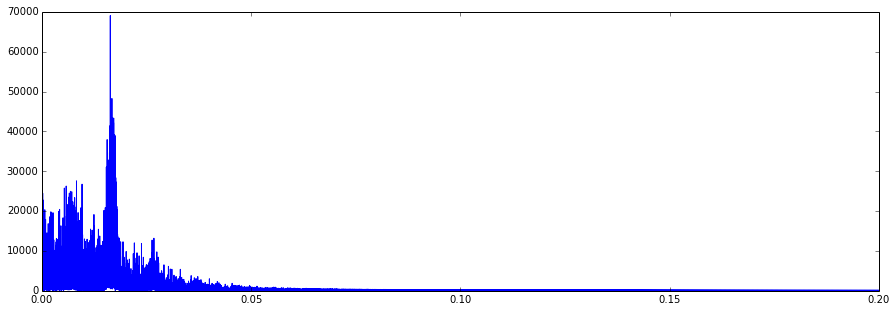

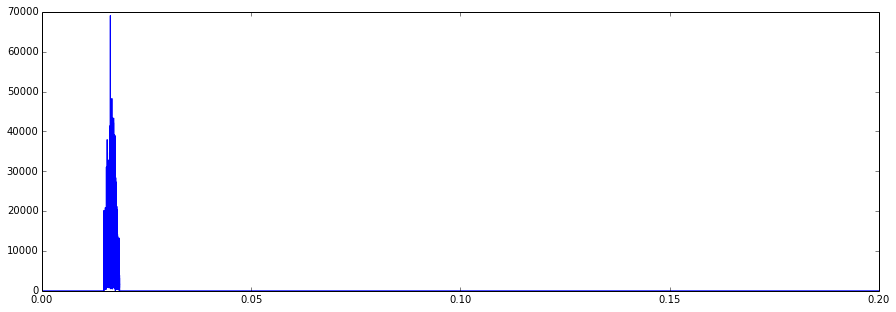

In [75]:
#########################################
###          Plot Signals             ###
#########################################
plotamp([xt, xr], xmin = 0, xmax = 2000)
plotamp([modsig_cut_signal, 
         #recovered, 
         recovered_cut_signal
        ], xmin = 0, xmax = 2000)
drawfft([recovered], xlow=0, xhigh=0.2, ylow=0, yhigh=0)
drawfft([recovered_cut_signal], xlow=0, xhigh=0.2, ylow=0, yhigh=0)

In [72]:
if (signal == dmodsig).all():
    print 'matched'
else:
    print 'error'
print hex(signal[6])
print hex(dmodsig[6])
print signal == dmodsig

matched
0xd716ade0a1f99b82L
0xd716ade0a1f99b82L
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


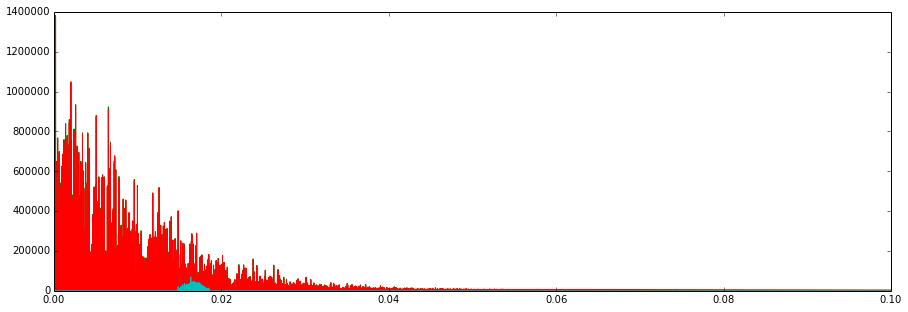

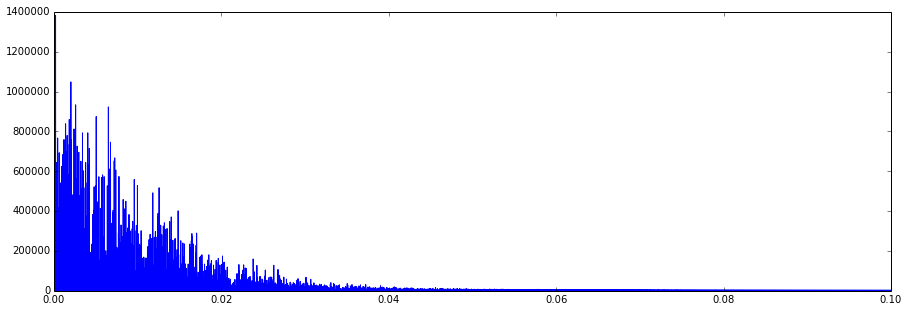

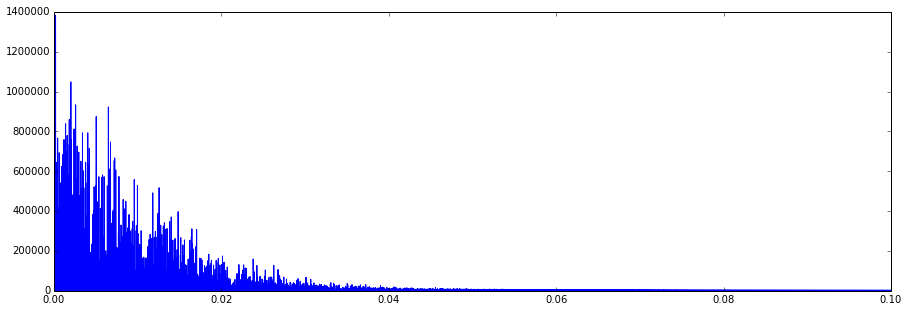

In [73]:
drawfft([modsig_cut_signal, xt, 
                    xr, recovered_cut_signal, 
                   ], xlow=0, xhigh=0.1, ylow=0, yhigh=0)

drawfft([xt,
                   ], xlow=0, xhigh=0.1, ylow=0, yhigh=0)

drawfft([encryptedx
                   ], xlow=0, xhigh=0.1, ylow=0, yhigh=0)

In [74]:
a = [2,3]
b = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
c = a * int(len(b)/len(a)) + a[:len(b)%len(a)]

In [ ]:
print c, int(len(b)/len(a))

In [21]:
def dd(recovered):
    #########################################
    ###         Frequency Domain          ###
    #########################################
    W = fftfreq(recovered.size, d=1)
    f_signal = rfft(recovered)
    #W = fftfreq(encryptedx.size, d=1)
    #f_signal = rfft(encryptedx)
    #W = fftfreq(modsig_cut_signal.size, d=1)
    #f_signal = rfft(modsig_cut_signal)

    #########################################
    ###              Filter               ###
    #########################################
    cut_f_signal = f_signal.copy()
    #print (W<0.5/p)
    #cut_f_signal[(W<1/p)] = 0
    #cut_f_signal[(W>0/p)] = 0
    cut_f_signal[(W>(2.0/p)+filter_del)] = 0
    cut_f_signal[(W<(2.0/p)-filter_del)] = 0
    #print 0.9/p, 0.5/p

    #########################################
    ###            Time Domain            ###
    #########################################
    recovered_cut_signal = irfft(cut_f_signal)

    #########################################
    ###        QPSK Demodulation          ###
    #########################################
    dmodsig = modulation.qpsk_demodulate(recovered_cut_signal)

    #########################################
    ###        Comparing Signals          ###
    #########################################
    #print signal, dmodsig
    if (signal == dmodsig).all():
        print 'matched'
    else:
        print 'error'    
    print signal == dmodsig


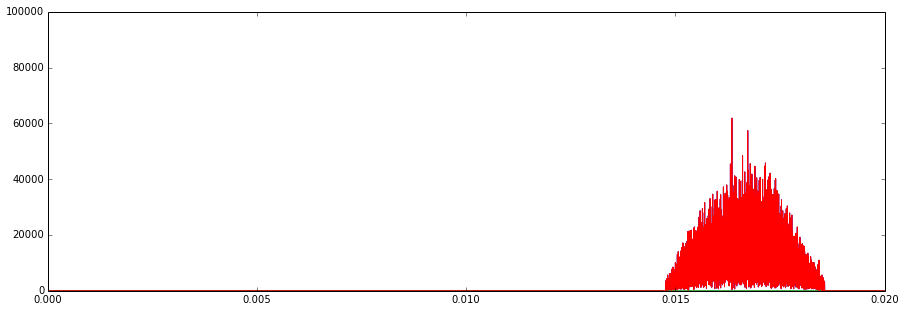

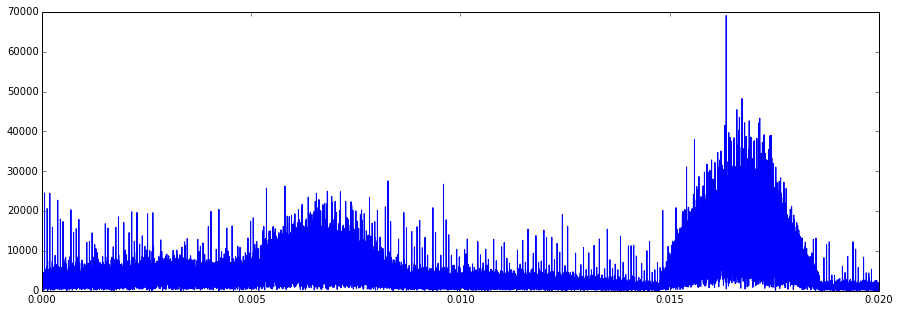

100
matched
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


None

<function __main__.f>

In [77]:
from IPython.html.widgets import *
def f(rho, sigma, beta):
    lorenz_attractor = Lorenz_Attractor(N = N, tstep = tstep, ndrop = ndrop, 
                                        rho = rho, sigma = sigma, beta = beta, 
                                        blocksize = blocksize, pregen=False)
    
    encryptedx, xt = lorenz_attractor.chaos_encrypt_block(modsig_cut_signal)
    #recovered, xr = lorenz_attractor.chaos_decrypt_block(encryptedx)
    drawfft([encryptedx, xt, modsig_cut_signal], xlow=0, xhigh=0.02, ylow=0, yhigh=100000)
    drawfft([recovered], xlow=0, xhigh=0.02, ylow=0, yhigh=0)
    dd(recovered)
    
interact(f, rho = (0,1000, 0.1), sigma = (0,40, 0.01), beta = (0,1, 0.01))
#interact(f)
#interact(f)